# Thompson Sampling - Step 3:
Optimization with uncertain conversion rates. Focus on the situation in which the binary features cannot be observed and therefore data are aggregated. Design bandit algorithms (based on UCB and TS) to face the case in which the conversion rates are unknown. Develop the algorithms by Python and evaluate their performance when applied to your simulator.

In [21]:
from Model.ConfigurationParametersAverage import mergeUserClasses
from Environment import Environment
from Learner.TS_CR import *
from Model.Product import *
import json
import matplotlib.pyplot as plt
from Model.Evaluator.GraphEvaluator import *

In [22]:
def total_margin_per_node(envReturn, marginsPerPrice, pulledArm):
    TotMargin = 0
    for e in envReturn["episodes"]:
        if e.bought:
            TotMargin += marginsPerPrice[e.product][pulledArm[e.product]] * e.units
    return TotMargin

In [23]:
files = ['./Configs/config1.json', './Configs/config3.json', './Configs/configuration4.json', './Configs/configuration5.json']
#files = ['./Configs/config1.json', './Configs/Config2.json']
env = []
tsLearners = []
config_margins = []
optimal_arms = []
conv_rates = []
prod_lists = []
click_probs = []
lambdas = []
alphas = []
units_means = []
clairvoyant_opt_rew = []
n_loops = 1

for i in range(0, len(files)):
    env.append(Environment(config_path=files[i]))
    config = mergeUserClasses([files[i]], False)[0]
    config_margins.append(config["marginsPerPrice"])
    optimal_arms.append(config["optimalConfig"])
    conv_rates.append(config["conversionRateLevels"])
    prod_lists.append(config["productList"])
    print("ProdList={}, Alphas={}, ConvRates={}".format(len(config["productList"]),len(config["alphas"]),len(config["conversionRateLevels"])))
    click_probs.append(config["click_prob"])
    lambdas.append(config['lambda_p'])
    alphas.append(config["alphas"])
    clairvoyant_opt_rew.append(config["optimalMargin"])
    units_means.append(config["units_mean"])

ProdList=5, Alphas=5, ConvRates=5
ProdList=5, Alphas=5, ConvRates=5
ProdList=5, Alphas=5, ConvRates=5
ProdList=5, Alphas=5, ConvRates=5


Optimal arm found:
	 [2, 2, 0, 3, 2] 
Optimal theoretical arm:
	 [2, 2, 0, 2, 2]
Optimal arm found:
	 [1, 1, 1, 1, 1] 
Optimal theoretical arm:
	 [1, 1, 1, 1, 1]
Optimal arm found:
	 [3, 3, 3, 3, 3] 
Optimal theoretical arm:
	 [3, 3, 3, 3, 3]
Optimal arm found:
	 [3, 2, 2, 2, 3] 
Optimal theoretical arm:
	 [3, 2, 2, 2, 3]


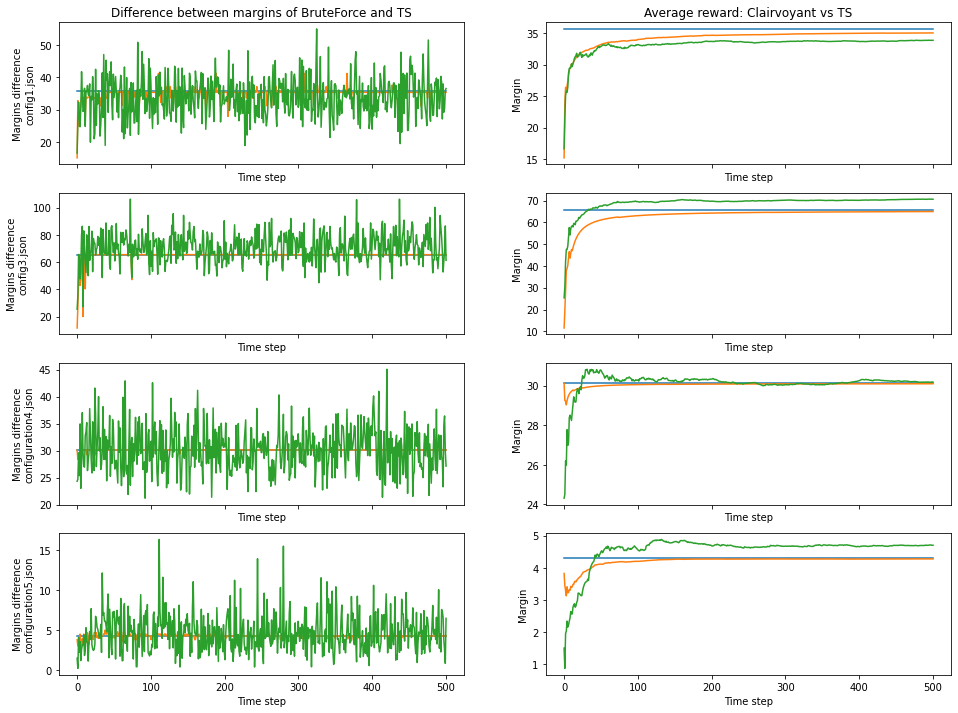

In [24]:
tot_ts_learner_margins = []
tot_optimal_margins = []
tsLearners = []
n_experiments = 500
fig, axes = plt.subplots(ncols=2, nrows=len(env), sharex=True, figsize=(16,12))

for i in range(0, len(env)):
    tsLearners.append(TS_CR(margins=config_margins[i], alphas=alphas[i], secondary_prod=prod_lists[i],
                            click_prob=click_probs[i], l=lambdas[i]))
    
    ts_learner_graph_margins = np.array([])
    ts_learner_env_margins = np.array([])

    for j in range(0, n_experiments):
        ts_single_margin = 0
        opt_single_margin = 0
        armMargins = []
        armConvRates = []

        # compute the margin for the TS
        pulledArm = tsLearners[i].pull_arm()
        for k in range(0, len(pulledArm)):
            armMargins.append(config_margins[i][k][pulledArm[k]])
            armConvRates.append(conv_rates[i][k][pulledArm[k]])

        graphEval = GraphEvaluator(products_list=prod_lists[i], click_prob_matrix=click_probs[i], lambda_prob=lambdas[i],
                    alphas=alphas[i], conversion_rates=armConvRates, margins=armMargins, units_mean=units_means[i], verbose=False)

        env[i].setPriceLevels(pulledArm)
        ts_interactions = env[i].round()
        ts_single_margin = graphEval.computeMargin()
                    
        ts_env_margin = 0
        for k in range(0,len(ts_interactions)):
            # ts_env_margin = 0
            ts_env_margin = ts_env_margin + ts_interactions[k].linearizeMargin(config_margins[i])
        ts_env_margin = ts_env_margin / len(ts_interactions)

        tsLearners[i].update(ts_interactions, pulledArm)

        ts_learner_graph_margins = np.append(ts_learner_graph_margins, ts_single_margin)
        ts_learner_env_margins = np.append(ts_learner_env_margins, ts_env_margin)

    opt_arms = optimal_arms[i]
    armMargins = []
    armConvRates = []
    for k in range(0, len(opt_arms)):
        armMargins.append(config_margins[i][k][opt_arms[k]])
        armConvRates.append(conv_rates[i][k][opt_arms[k]])
    graphEval = GraphEvaluator(products_list=prod_lists[i], click_prob_matrix=click_probs[i], lambda_prob=lambdas[i],
                    alphas=alphas[i], conversion_rates=armConvRates, margins=armMargins, units_mean=units_means[i], verbose=False)
    
    # optimal = np.full((n_experiments), clairvoyant_opt_rew[i])
    optimal = np.full((n_experiments), graphEval.computeMargin())
    
    config_name = files[i][files[i].rfind('/')-len(files[i])+1:]

    x = np.linspace(0, n_experiments, n_experiments)
    axes[i,0].plot(x, optimal)
    axes[i,0].plot(x, ts_learner_graph_margins)
    axes[i,0].plot(x, ts_learner_env_margins)
    axes[i,0].set_xlabel("Time step")
    axes[i,0].set_ylabel("Margins difference\n{}".format(config_name))
    axes[0,0].set_title("Difference between margins of BruteForce and TS")

    axes[i,1].plot(x,optimal)
    cum_rews = np.cumsum(ts_learner_graph_margins)
    avg_cum_rews = np.divide(cum_rews, np.arange(1,n_experiments+1))
    axes[i,1].plot(x, avg_cum_rews)
    cum_rews = np.cumsum(ts_learner_env_margins)
    avg_cum_rews = np.divide(cum_rews, np.arange(1,n_experiments+1))
    axes[i,1].plot(x, avg_cum_rews)
    axes[i,1].set_xlabel("Time step")
    axes[i,1].set_ylabel("Margin")
    axes[0,1].set_title("Average reward: Clairvoyant vs TS")
    print("Optimal arm found:\n\t", tsLearners[i].pull_arm(), "\nOptimal theoretical arm:\n\t", optimal_arms[i])

plt.show()
